This is similar to the 'NN' notebook, but will use convolutional neural networks instead of normal neural nets on flattened arrays of the data.

In [34]:
# Standard scientific Python imports
import matplotlib.pyplot as plt
%matplotlib inline

# Import datasets, classifiers and performance metrics
from sklearn import datasets, svm, metrics

# The digits dataset
digits = datasets.load_digits()

# The data that we are interested in is made of 8x8 images of digits, let's
# have a look at the first 4 images, stored in the `images` attribute of the
# dataset.  If we were working from image files, we could load them using
# matplotlib.pyplot.imread.  Note that each image must have the same size. For these
# images, we know which digit they represent: it is given in the 'target' of
# the dataset.

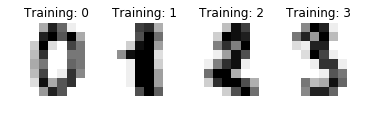

In [36]:
images_and_labels = list(zip(digits.images, digits.target))
for index, (image, label) in enumerate(images_and_labels[:4]):
    plt.subplot(2, 4, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title('Training: %i' % label)

In [44]:
# To apply a classifier on this data, we need to flatten the image, to
# turn the data in a (samples, feature) matrix:
from keras.utils.np_utils import to_categorical
digits.target_cat = to_categorical(digits.target)

n_samples = len(digits.images)
data = digits.images
X_train = data[:n_samples // 2]
X_test = data[n_samples // 2:]
y_train = digits.target_cat[:n_samples // 2]
y_test = digits.target_cat[n_samples // 2:]

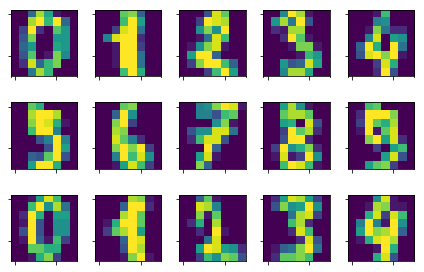

In [45]:
fig, axes = plt.subplots(nrows=3, ncols=5)
for j in range(3):
    for i in range(5):
        axes[j, i].imshow(X_train[j*5 + i])
        axes[j, i].set_xticklabels([])
        axes[j, i].set_yticklabels([])
plt.tight_layout()

In [46]:
X_train2 = X_train.reshape(X_train.shape[0], 1, X_train.shape[1], X_train.shape[2]) #reshape to have depth of 1
X_test2 = X_test.reshape(X_test.shape[0], 1, X_test.shape[1], X_test.shape[2]) #need that for convolutions
X_train2 = X_train2.astype('float32') #make it float
X_test2 = X_test2.astype('float32')
X_train2 /= 16 #scale 0 to 1
X_test2 /= 16

Using https://elitedatascience.com/keras-tutorial-deep-learning-in-python as a guide

In [50]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D

In [69]:
from keras.callbacks import EarlyStopping
from numpy.random import seed
seed(8)
model = Sequential()
model.add(Conv2D(10, (2, 2), activation='relu', input_shape=X_train2.shape[1:], data_format='channels_first'))
model.add(Conv2D(16, 2, 2, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(10, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train2, y_train, validation_split=0.3, epochs=50, callbacks=[EarlyStopping(patience=2)])

/Users/muneebalam/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (2, 2), activation="relu")`
  


Train on 628 samples, validate on 270 samples
Epoch 1/50
628/628 [==============================] - 0s - loss: 2.2557 - acc: 0.1545 - val_loss: 2.2051 - val_acc: 0.1889
Epoch 2/50
628/628 [==============================] - 0s - loss: 2.1600 - acc: 0.2834 - val_loss: 2.1003 - val_acc: 0.4370
Epoch 3/50
628/628 [==============================] - 0s - loss: 2.0308 - acc: 0.4602 - val_loss: 1.9538 - val_acc: 0.5407
Epoch 4/50
628/628 [==============================] - 0s - loss: 1.8479 - acc: 0.5717 - val_loss: 1.7591 - val_acc: 0.6704
Epoch 5/50
628/628 [==============================] - 0s - loss: 1.6320 - acc: 0.6640 - val_loss: 1.5233 - val_acc: 0.7481
Epoch 6/50
628/628 [==============================] - 0s - loss: 1.3949 - acc: 0.7102 - val_loss: 1.2816 - val_acc: 0.8037
Epoch 7/50
628/628 [==============================] - 0s - loss: 1.1662 - acc: 0.7675 - val_loss: 1.0747 - val_acc: 0.8000
Epoch 8/50
628/628 [==============================] - 0s - loss: 1.0082 - acc: 0.7755 - val_l

In [71]:
predictions = model.predict(X_test2)
# The classification report required 1D arrays, so I'll convert everything to max probability
from numpy import argmax
predictions1D = argmax(predictions, axis=1) #should have shape (899,)
y_test1D = argmax(y_test, axis=1)
report = metrics.classification_report(y_test1D, predictions1D)

import pandas as pd #for formatting
df = pd.DataFrame([x.split() for x in report.replace('/', '\n').split('\n')]) #have a problematic slash in there
from numpy import concatenate, array
df.columns = concatenate([array(['Digit']), df.iloc[0,:-1]])
df.drop(df.index[:2], inplace=True)
df.set_index('Digit', inplace=True)
df.drop(df.index[pd.isnull(df.index.values)], inplace=True)
df

,precision,recall,f1-score,support
Digit,,,,
0,0.99,0.97,0.98,88
1,0.90,0.73,0.80,91
2,0.92,0.90,0.91,86
3,0.90,0.86,0.88,91
4,0.96,0.95,0.95,92
5,0.93,0.97,0.95,91
6,0.93,0.98,0.95,91
7,0.94,0.85,0.89,89
8,0.74,0.81,0.77,88


This looks like it stabilized around 90% accuracy. 

In [72]:
sum(predictions1D == y_test1D)/len(y_test1D)

0.89543937708565069

This is a little better than the other neural network but still much worse than, say, SVM, which got to 97%.